#**ANLY590 Homework 3** 
**Kate Bosshart (keb289@georgetown.edu) | Due 06DEC2019**

---
---

In [1]:
!pip install tensorflow==1.7
!pip install tensorflow_hub

In [2]:
import tensorflow as tf
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

'1.7.0'

In [3]:
import keras
from keras import regularizers, models, layers, optimizers, callbacks 
from keras import backend as K
from keras.datasets import fashion_mnist 
from keras.utils import to_categorical, np_utils
from keras.layers import Activation, Flatten, Input, Dense, Conv1D, Conv2D, Dropout, MaxPooling2D, UpSampling2D, RepeatVector
from keras.layers import LSTM, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import RMSprop

import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from google.colab import files, drive

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

Using TensorFlow backend.


### **1. Autoencoder**

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of Dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.
Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we’ve used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this post https://blog.keras.io/building-autoencoders-in-keras.html. DO NOT JUST COPY THIS CODE AND TURN IT IN. BE CREATIVE, COME UP WITH YOUR OWN VARIATION.


After training your network, visualize some examples of input images and their decoded reconstruction.



***Prep the MNIST Data***

In [0]:
# IMPORT THE DATA
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [0]:
# PREP THE DATA
## flatten the 28x28 images into vectors of size 784
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [27]:
# Confirm we have the flattened vectors of size 784
print(x_train.shape)
print(x_test.shape)

# Dim of image is 28x28x1 - which gives us the flattened 784 pixels

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [28]:
# Placeholder input image
input_img = Input(shape=(28,28,1))

print(input_img.shape)

(?, 28, 28, 1)


***Build & fit a convolutional autoencoder***

In [0]:
# ENCODER
## Encoder should run input image thru few convolutional layers of your choice
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

# "Encoded" is the encoded representation of the input
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [30]:
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
print(encoded.shape)

(?, 2, 2, 8)


In [0]:
# DECODER
## Decoder will utilize UpSampling2D to get representation back to original image size.
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)


# "Decoded" reverts the encoded representation back to the shape of the input
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [48]:
# After going thru the Decoder, the representation is (28, 28, 1) - same as our original image
print(decoded.shape)

(?, 28, 28, 1)


In [49]:
# Combine into a model that maps input to its encoded representation
autoencoder = Model(input_img, decoded)

# Configure model w per-pixel binary crossentropy loss & Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 16)          0   

In [50]:
# Incorporate early stopping 
from keras.callbacks import EarlyStopping  

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')

# Train model
history = autoencoder.fit(x_train, 
                          x_train, 
                          epochs=25, 
                          batch_size= 135, 
                          shuffle = True, 
                          validation_data=(x_test, x_test), 
                          callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 199s 3ms/step - loss: 0.5241 - val_loss: 0.4107
Epoch 2/25
60000/60000 [==============================] - 198s 3ms/step - loss: 0.3967 - val_loss: 0.3970
Epoch 3/25
60000/60000 [==============================] - 196s 3ms/step - loss: 0.3739 - val_loss: 0.3576
Epoch 4/25
60000/60000 [==============================] - 196s 3ms/step - loss: 0.3998 - val_loss: 0.4290
Epoch 5/25
60000/60000 [==============================] - 196s 3ms/step - loss: 0.4187 - val_loss: 0.4188
Epoch 6/25
60000/60000 [==============================] - 195s 3ms/step - loss: 0.4169 - val_loss: 0.4540
Epoch 7/25
60000/60000 [==============================] - 194s 3ms/step - loss: 0.4140 - val_loss: 0.4136
Epoch 8/25
60000/60000 [==============================] - 194s 3ms/step - loss: 0.4094 - val_loss: 0.4016
Epoch 9/25
60000/60000 [==============================] - 195s 3ms/step - loss: 0.4330 - val_loss: 0.4

The model is oscelating and having trouble finding the minima. Need to try again with a smaller step size to see if that will help.

In [51]:
# 2nd ATTEMPT:
history = autoencoder.fit(x_train, 
                          x_train, 
                          epochs=25, 
                          batch_size= 105, 
                          shuffle = True, 
                          validation_data=(x_test, x_test), 
                          callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 202s 3ms/step - loss: 0.4463 - val_loss: 0.4407
Epoch 2/25
60000/60000 [==============================] - 201s 3ms/step - loss: 0.4524 - val_loss: 0.4378
Epoch 3/25
60000/60000 [==============================] - 201s 3ms/step - loss: 0.4689 - val_loss: 0.4715
Epoch 4/25
60000/60000 [==============================] - 199s 3ms/step - loss: 0.4742 - val_loss: 0.4568
Epoch 5/25
60000/60000 [==============================] - 199s 3ms/step - loss: 0.4819 - val_loss: 0.4877
Epoch 6/25
60000/60000 [==============================] - 200s 3ms/step - loss: 0.4898 - val_loss: 0.4848
Epoch 7/25
60000/60000 [==============================] - 200s 3ms/step - loss: 0.4912 - val_loss: 0.4844
Epoch 8/25
60000/60000 [==============================] - 199s 3ms/step - loss: 0.5069 - val_loss: 0.5118
Epoch 9/25
60000/60000 [==============================] - 200s 3ms/step - loss: 0.4986 - val_loss: 0.4

When we reduced the batch size, the results got worse but are still roughly the same as the last run

***Visualize Examples of Input Images & Their Decoded Reconstruction***

In [0]:
# Encode & Decode the Test Images

#encoded_imgs = encoder.predict(x_test)
#decoded_imgs = decoded.predict(encoded_imgs)
decoded_imgs = autoencoder.predict(x_test)


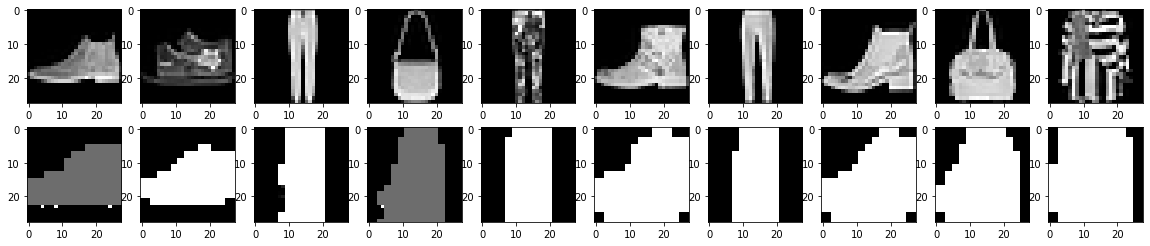

In [53]:
## Visualize an Example
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[-i].reshape(28, 28))
    plt.gray()

    if decoded_imgs is not None:
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[-i].reshape(28, 28))
        plt.gray()
plt.show()

The decoded images do not look like the input - a sign that information was lost in the training, which corresponds to what we expected based on the loss above. We can see that the model caputures the rough shape and shading, ut not much detail.

In [0]:
# Map input to encoded representation
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

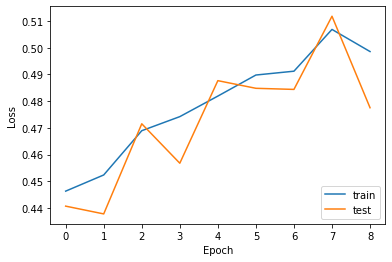

In [57]:
# Evaluate
def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Convolutional Autoencoder Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

plot_train_history_loss(history)

The plot shows that the loss actually increased with each epoch, rather than decreasing, and then might have found a local minima at the end, where it slightly decreased.

###**2. Image Classification**
We’ll continue to use the Fashion MNIST dataset and build a deep convolutional network for classification.


REFERENCE: https://towardsdatascience.com/mnist-cnn-python-c61a5bce7a19


In [0]:
# IMPORT & PREP THE DATA
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

train_X = train_X / 255
test_X = test_X / 255

In [0]:
# One Hot Encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

**2.1 Deep CNN**

Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model’s performance on training set and test set.


In [0]:
# build the Deep CNN Model 
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(28, 28, 1)))   # 64 neurons (feature maps) and a 3x3 feature detector
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))     # use max pooling with a 2x2 matrix

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))     # use max pooling with a 2x2 matrix

model.add(Flatten())
model.add(Dense(64))                         # implements the operation output = activation(dot(input, weight) + bias)

#model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))


In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
activation_19 (Activation)   (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_20 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)             

In [105]:
# Incorporate early stopping 
#from keras.callbacks import EarlyStopping  

#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')

# Train model
model.fit(train_X, train_Y_one_hot, batch_size=64, epochs=15)
                   #,
                   #validation_data=(test_X, test_Y),
                   #callbacks= [eary_stopping])

Epoch 1/15
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1433 - acc: 0.9470
Epoch 2/15
60000/60000 [==============================] - 129s 2ms/step - loss: 0.1345 - acc: 0.9506
Epoch 3/15
60000/60000 [==============================] - 128s 2ms/step - loss: 0.1256 - acc: 0.9533
Epoch 4/15
60000/60000 [==============================] - 128s 2ms/step - loss: 0.1200 - acc: 0.9552
Epoch 5/15
60000/60000 [==============================] - 129s 2ms/step - loss: 0.1130 - acc: 0.9583
Epoch 6/15
60000/60000 [==============================] - 127s 2ms/step - loss: 0.1092 - acc: 0.9594
Epoch 7/15
60000/60000 [==============================] - 127s 2ms/step - loss: 0.1035 - acc: 0.9614
Epoch 8/15
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0981 - acc: 0.9628
Epoch 9/15
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0959 - acc: 0.9644
Epoch 10/15
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0897 - a

In [0]:
from keras.models import model_from_json
from numpy import loadtxt
from keras.models import load_model

In [122]:
# SAVE MODEL

# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

# load model
model = load_model('model.h5')

Saved model to disk


In [115]:
# Evaluate Model & Validate results with test data
test_loss, test_acc = model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss', test_loss*100, "%")
print('Test accuracy', test_acc*100, "%")

Test loss 42.944968256950375 %
Test accuracy 89.94 %


Based on the fact that the accuracy is so much lower for the test data than for the training data, there is evidence to suggest that we may have overfit the model to our training data.

In [108]:
predictions = model.predict(test_X)
print(np.argmax(np.round(predictions[0])))

9


In [0]:
# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

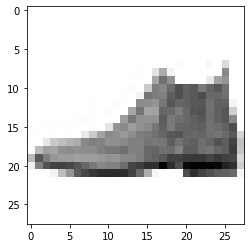

In [109]:
plt.imshow(test_X[0].reshape(28, 28), cmap = plt.cm.binary)
plt.show()

Based on the prediction, the label names, and the image, we can tell that the model correctly classified the image as an ankle boot.

**2.2 Transfer Learning**

Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model’s performance on training set and test set.

In [0]:
# IMPORT & PREP THE DATA
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

# Convert images into 3 channels
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape,test_X.shape

# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1,28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

# Resize the images to 48x48 for VGG16
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
train_X.shape, test_X.shape

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255
test_X = test_X / 255


In [128]:
# Converting Labels to one hot encoded format
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Splitting train data as train and validation data
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.3, random_state=27)

train_X.shape,
valid_X.shape,
train_label.shape,
valid_label.shape

(18000, 10)

In [129]:
# Preprocess Data 
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

#  VGG16 Model
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(48, 48, 3))   # use pretrained weights
conv_base.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

In [130]:
# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size=16, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=16, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=16, verbose=1)


18000/18000 [==============================] - 789s 44ms/step


In [0]:
# Save features 
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

In [132]:
print(train_features.shape)
print(test_features.shape)
print(val_features.shape)

(42000, 1, 1, 512)
(10000, 1, 1, 512)
(18000, 1, 1, 512)


In [0]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (42000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (18000, 1*1*512))

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [0]:
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))       # Densely connected classifier
model.add(layers.LeakyReLU(alpha=0.1))                                     # leakyrelu layer
model.add(layers.Dense(10, activation='softmax'))                          # dense layer for the number of classes

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])

In [149]:
# Incorporate reduced learning and early stopping for callback
#reduce_learning = callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=2, min_lr=0)
#early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
#callbacks = [#reduce_learning, 
 #            early_stopping]

# Train model
#history = model.fit(train_features_flat, train_label, epochs=55, validation_data=(val_features_flat, valid_label), callbacks=callbacks)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
model = model.fit(train_features_flat, train_label, batch_size=125, epochs=125, validation_data=(val_features_flat, valid_label), callbacks=[early_stopping])


Train on 42000 samples, validate on 18000 samples
Epoch 1/125
42000/42000 [==============================] - 6s 136us/step - loss: 1.7562 - acc: 0.3702 - val_loss: 1.4048 - val_acc: 0.5052
Epoch 2/125
42000/42000 [==============================] - 5s 118us/step - loss: 1.3191 - acc: 0.5232 - val_loss: 1.2143 - val_acc: 0.5588
Epoch 3/125
42000/42000 [==============================] - 5s 121us/step - loss: 1.1580 - acc: 0.5877 - val_loss: 1.1012 - val_acc: 0.6072
Epoch 4/125
42000/42000 [==============================] - 5s 123us/step - loss: 1.0695 - acc: 0.6205 - val_loss: 1.0910 - val_acc: 0.6443
Epoch 5/125
42000/42000 [==============================] - 5s 118us/step - loss: 1.0049 - acc: 0.6444 - val_loss: 0.9669 - val_acc: 0.6667
Epoch 6/125
42000/42000 [==============================] - 5s 121us/step - loss: 0.9680 - acc: 0.6552 - val_loss: 0.9522 - val_acc: 0.6549
Epoch 7/125
42000/42000 [==============================] - 5s 116us/step - loss: 0.9362 - acc: 0.6672 - val_loss: 0.

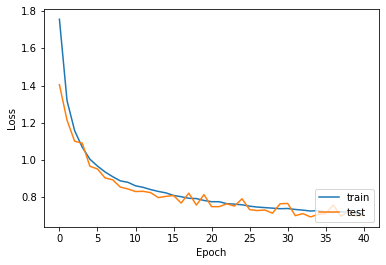

In [152]:
# Evaluate
def plot_train_history_loss(model):
    # summarize history for loss
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    #plt.title('Convolutional Autoencoder Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

plot_train_history_loss(model)

###**3. Text Classification**

While images contain local spatial correlations and structure, many other datasets contain temporal correlations. Examples include time series and discrete sequences such as text. In this problem, we will tackle the task of text classification in the context of natural language.

**Background** In this problem, we will build models that read short text segments (tweets) and identify if one or more specific topics are being discussed. 

**Dataset** The dataset consists of tweets along with labels for which topics were being referenced in the tweet. Examples of the topics include ”storms”, ”rain”, ”hurricane”, ”snow” and so on. Unlike previous classification problems we have encountered, in this dataset, there is not just a single right answer. The labels here are derived from multiple annotators decided how to label each tweet, so a single tweet can be about more than one topic. The label is the
fraction of annotations for a given topic, and each row should sum to 1.

What Loss function should you use here? Categorical CrossEntropy might work, but with some modification since we don’t have ”hard” labels over the categories. Another option might be sigmoid: for each output category, use a sigmoid to collapse the output to between 0 and 1, but each category output can be roughly independent of the others. In the problems below, feel free to
try both.

REFERENCE: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [202]:
# IMPORT THE DATA
import pandas as pd
tweets = open("tweets_with_labels.csv")
lines = tweets.readlines()
tweets.close()

lines = [line.strip('\n') for line in lines]
tweettext = [line.split("\t") for line in lines]
header = tweettext[0]

# Check the shape of the data
print(len(header))
print(len(tweettext))


tweettext = [c for c in tweettext[1:] if len(c)==17]
print(len(tweettext))

tweets = pd.DataFrame(columns=header, data=tweettext)

## Rename the columns
tweets.rename(columns = {'k1':'clouds'}, inplace = True) 
tweets.rename(columns = {'k2':'cold'}, inplace = True) 
tweets.rename(columns = {'k3':'dry'}, inplace = True) 
tweets.rename(columns = {'k4':'hot'}, inplace = True) 
tweets.rename(columns = {'k5':'humid'}, inplace = True) 
tweets.rename(columns = {'k6':'hurricane'}, inplace = True) 
tweets.rename(columns = {'k7':'icanttell'}, inplace = True) 
tweets.rename(columns = {'k8':'ice'}, inplace = True) 
tweets.rename(columns = {'k9':'other'}, inplace = True) 
tweets.rename(columns = {'k10':'rain'}, inplace = True) 
tweets.rename(columns = {'k11':'snow'}, inplace = True) 
tweets.rename(columns = {'k12':'storms'}, inplace = True) 
tweets.rename(columns = {'k13':'sun'}, inplace = True) 
tweets.rename(columns = {'k14':'tornado'}, inplace = True) 
tweets.rename(columns = {'k15':'wind'}, inplace = True) 

# Check the first 5 rows of data - each row should sum to 1
tweets[:5]


17
77947
77847


,id,tweet,clouds,cold,dry,hot,humid,hurricane,icanttell,ice,other,rain,snow,storms,sun,tornado,wind
0,1,Jazz for a Rainy Afternoon: {link},0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,RT: @mention: I love rainy days.,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,Good Morning Chicago! Time to kick the Windy C...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0,0,0,0,0,0,0.604,0,0.196,0,0,0,0.201,0,0
4,9,@mention good morning sunshine,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [214]:
# CLEAN THE DATA

# Remove mentions as these shouldnt count as text
tweets["tweet"] = tweets["tweet"].apply(lambda x : ' '.join([w for w in x.split() if not w.startswith('@') ])  ) 

# Split up the text and the labels
TEXT = tweets["tweet"].values
LABELS = tweets.iloc[:,2:].values

# Remove symbols and numbers from text
import re
TEXT = np.array(list(map(lambda i: re.sub('[^a-zA-Z]', ' ', i), TEXT)))
TEXT = np.array(list(map(lambda i: re.sub(r'\s+', ' ', i), TEXT)))

TEXT[:5]

array(['Jazz for a Rainy Afternoon link ', 'RT I love rainy days ',
       'Good Morning Chicago Time to kick the Windy City in the nuts and head back West ',
       'Preach lol RT alliwantis this type of weather all the time I live for beautiful days like this minneapolis',
       'good morning sunshine'], dtype='<U167')

In [215]:
# SPLIT 30:70 for TEST/TRAIN
TEXT_train, TEXT_test, LABEL_train, LABEL_test = train_test_split(TEXT, 
                                                                  LABELS, 
                                                                  test_size=0.30, 
                                                                  random_state=27)

print(TEXT_train.shape,LABEL_train.shape)
print(TEXT_test.shape,LABEL_test.shape)

(54492,) (54492, 15)
(23355,) (23355, 15)


In [216]:
#TOKENIZE TWEETS

tk = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tk.fit_on_texts(TEXT_train)
tk.fit_on_texts(TEXT_test)

word_index = tk.word_index
print('Found %s unique tokens.' % len(word_index))

train_tokenized = tk.texts_to_sequences(TEXT_train)
test_tokenized = tk.texts_to_sequences(TEXT_test)

TEXT_train = pad_sequences(train_tokenized, maxlen = 250)
TEXT_test = pad_sequences(test_tokenized, maxlen = 250)

print('Shape of Train data tensor:', TEXT_train.shape)
print('Shape of Test data tensor:', TEXT_test.shape)

TEXT = pad_sequences(sequences, maxlen=500)


Found 39667 unique tokens.
Shape of Train data tensor: (54492, 250)
Shape of Test data tensor: (23355, 250)


In [182]:
## USE GLOVE FOR WORD EMBEDDINGS

pip install glove_python

from glove import Corpus, Glove

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700333 sha256=f34222a778fabefd4e3313a0aee504217693edde0e7f7afbb9ae8304a3bf6270
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


**3.1 RNN**

Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

*  The first layer is the embedded layer that uses 100 length vectors to represent each word.

*  SpatialDropout1D performs variational dropout in NLP models.

*  The next layer is the LSTM layer with 100 memory units.

*  The output layer must create 13 output values, one for each class.

*  Activation function is softmax for multi-class classification.

*  Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [0]:
from keras.layers import SpatialDropout1D

In [221]:
model = Sequential()
model.add(Embedding(50000, 100, input_length=TEXT.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(TEXT_train, 
                    LABEL_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1)


ValueError: ignored

**3.2 CNN**

Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings). You might gain some insight and inspiration from these text classification approaches:

• http://www.aclweb.org/anthology/D14-1181

• https://arxiv.org/abs/1702.08568

**3.3 Comparison**

Be sure to directly compare your two methods with an ROC curve or similar validation method. Don’t forget to create a train-test split.